# Section 0: Setup

Install necessary imports


In [1]:
import pandas as pd
import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Conv1D,MaxPooling1D,Flatten
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Section 1: Data Loading and Pre Processing


Load data

In [33]:
data_url = 'https://media.githubusercontent.com/media/apodrug/9S912-FP/main/9s-training.csv'
df = pd.read_csv(data_url)
print(df['Sleep Stage'].value_counts())

SLEEP-S2     341155
SLEEP-REM    219790
SLEEP-S3     152417
SLEEP-S0     137679
SLEEP-S1     112079
Name: Sleep Stage, dtype: int64


Edit sleep stage labels from strings to integers

In [3]:
def get_stage(x):
  if x == 'SLEEP-S0':
    return 0
  elif x== 'SLEEP-S1':
    return 1
  elif x=='SLEEP-S2':
    return 2
  elif x=='SLEEP-S3':
    return 3
  elif x=='SLEEP-REM':
    return 4

df['Stage - Indexed'] = df['Sleep Stage'].apply(get_stage)

Shuffle and split dataset into training and testing inputs and outputs

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

x_train = train.loc[:, ~train.columns.isin(['Unnamed: 0','Unnamed: 0.1','Sleep Stage','S3','ID', 'Time', 'Stage - Indexed'])]
y_train = train.loc[:, 'Stage - Indexed']

x_test = test.loc[:, ~test.columns.isin(['Unnamed: 0','Unnamed: 0.1','Sleep Stage','S3','ID', 'Time', 'Stage - Indexed'])]
y_test = test.loc[:, 'Stage - Indexed']

Normalize all data to between 0 and 1 by max values of every column

In [5]:
max_vals = df.max()
def average_col(col):
  return col/max_vals[col.name]
x_train = x_train.apply(average_col,0)
x_test = x_test.apply(average_col,0)

Reformat and reshape data to pass into CNN model

In [6]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

y_train=y_train.astype(int)
y_test=y_test.astype(int)
y_train_onehot = to_categorical(y_train, num_classes=5)
y_test_onehot = to_categorical(y_test, num_classes=5)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

#Section 2: Training and Testing CNN Model

Set up model

In [24]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(MaxPooling1D(pool_size=3 ))
model.add(Conv1D(filters=64, kernel_size=5))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

Train model

In [25]:
class_weight = {0:1.39847356,1:1.71707839,2:0.56466243,3:1.26442444,4:0.87664949} # got using sklearn.utils.class_weight.compute_class_weight
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(x_train, y_train_onehot, epochs=50, batch_size=64, verbose=2, class_weight=class_weight)

Epoch 1/50
12039/12039 - 34s - loss: 1.4174 - accuracy: 0.3700 - 34s/epoch - 3ms/step
Epoch 2/50
12039/12039 - 33s - loss: 1.3234 - accuracy: 0.4289 - 33s/epoch - 3ms/step
Epoch 3/50
12039/12039 - 33s - loss: 1.2669 - accuracy: 0.4592 - 33s/epoch - 3ms/step
Epoch 4/50
12039/12039 - 33s - loss: 1.2231 - accuracy: 0.4804 - 33s/epoch - 3ms/step
Epoch 5/50
12039/12039 - 33s - loss: 1.1865 - accuracy: 0.4985 - 33s/epoch - 3ms/step
Epoch 6/50
12039/12039 - 33s - loss: 1.1585 - accuracy: 0.5120 - 33s/epoch - 3ms/step
Epoch 7/50
12039/12039 - 33s - loss: 1.1349 - accuracy: 0.5236 - 33s/epoch - 3ms/step
Epoch 8/50
12039/12039 - 33s - loss: 1.1161 - accuracy: 0.5314 - 33s/epoch - 3ms/step
Epoch 9/50
12039/12039 - 33s - loss: 1.0989 - accuracy: 0.5388 - 33s/epoch - 3ms/step
Epoch 10/50
12039/12039 - 33s - loss: 1.0836 - accuracy: 0.5455 - 33s/epoch - 3ms/step
Epoch 11/50
12039/12039 - 33s - loss: 1.0696 - accuracy: 0.5520 - 33s/epoch - 3ms/step
Epoch 12/50
12039/12039 - 33s - loss: 1.0577 - accur

Test model and get outputs for analyzation'

In [26]:
trainScore = model.evaluate(x_train, y_train_onehot, verbose=0)
testScore = model.evaluate(x_test, y_test_onehot, verbose=0)
probabilities = model.predict(x_test)

print(trainScore)
print(testScore)

6020/6020 [==============================] - 9s 1ms/step
[0.8908761143684387, 0.658043622970581]
[1.1034963130950928, 0.6150323748588562]


#Section 4: Analyzation


## Learning/Optimization: Training Loss vs Epoch

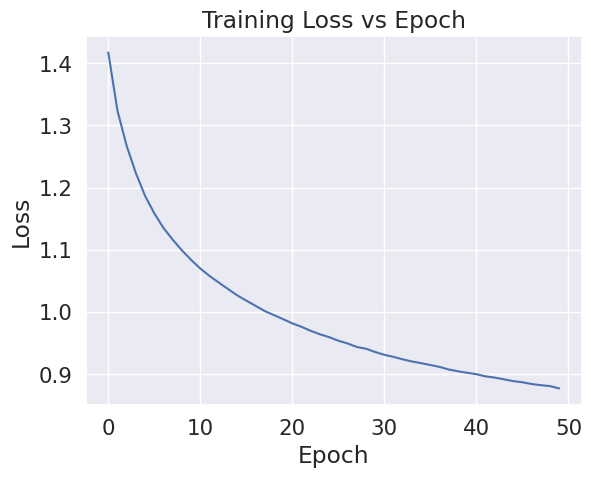

In [27]:
plt.plot(history.history['loss'])
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

  ## Visualizing Accuracy of Model: Confusion Matrix

  Indexed Sleep Stages:

    0 Wake
    1 Stage 1
    2 Stage 2
    3 Stage 3
    4 REM

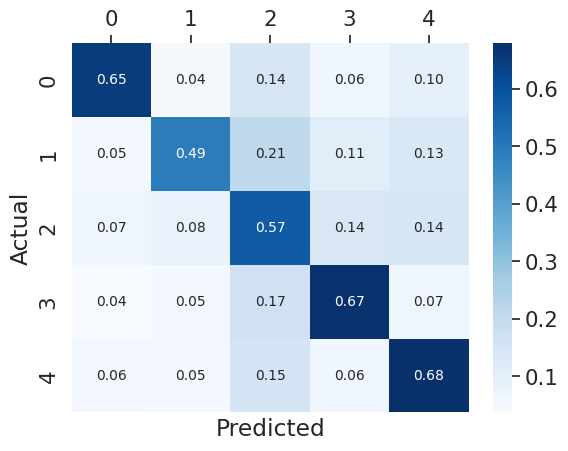

In [28]:
prediction = np.argmax(probabilities, axis=1) #transform one hot encodings to class labels
stages = y_test
cm = confusion_matrix(stages, prediction) #get confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #normalize confusion matrix to between 0 and 1

'''plot confusion matrix'''
df_cm = pd.DataFrame(cm)
sn.set(font_scale=1.4)
ax = sn.heatmap(df_cm, annot=True, cmap='Blues', annot_kws={"size": 10}, fmt='.2f')
ax.set(xlabel="Predicted", ylabel="Actual")
ax.xaxis.tick_top()

  ##  Equivariance: Conv1D Learned Layer Weights Visualization


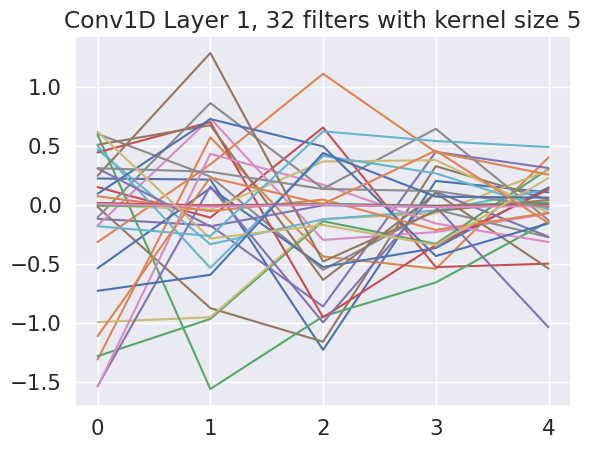

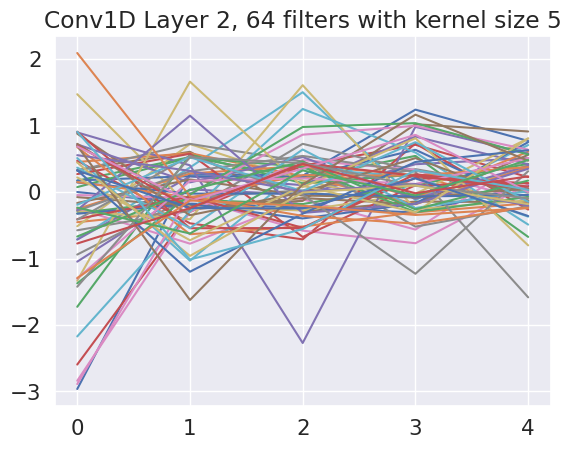

In [29]:
''' 1st filter, Conv1d '''
filters, biases = model.layers[0].get_weights()
for i in range(filters.shape[2]):  # for each filter in 1st Conv1D layer
    f = filters[:, 0, i] #Get weights
    plt.plot(f)
plt.title(f'Conv1D Layer 1, 32 filters with kernel size 5')
plt.show()
plt.clf()



''' 2nd filter, Conv1d '''
filters, biases = model.layers[2].get_weights()
for i in range(filters.shape[2]): #for each filter in 2nd Conv1D
    f = filters[:, 0, i] # Get weights
    plt.plot(f)
plt.title(f'Conv1D Layer 2, 64 filters with kernel size 5')
plt.show()

## Principle Component Analysis of Model Outputs

Recreate trained model to get the second to last layer outputs

In [30]:
intermediate_model = Sequential()

for layer in model.layers[:-1]:  # Exclude the last layer
  intermediate_model.add(layer)
intermediate_output = intermediate_model.predict(x_test)

6020/6020 [==============================] - 8s 1ms/step


Perform PCA to get 3 dimensions values

In [31]:

NCOMPONENTS = 3

pca = PCA(n_components=NCOMPONENTS)
pca.fit(intermediate_output)
x=pca.transform(intermediate_output)

Graphing 3D and 2D PCA Plots

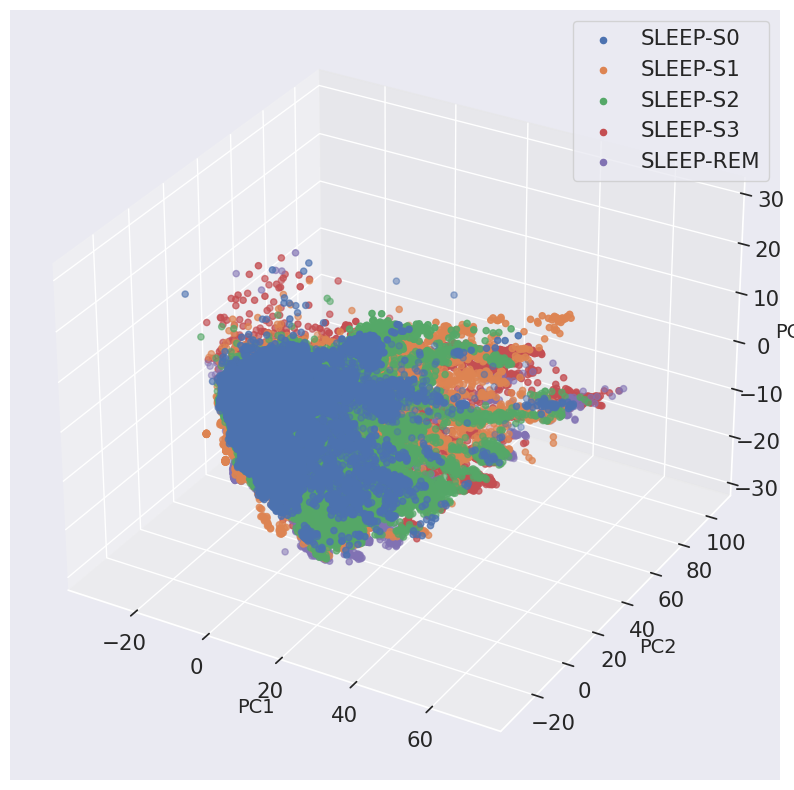

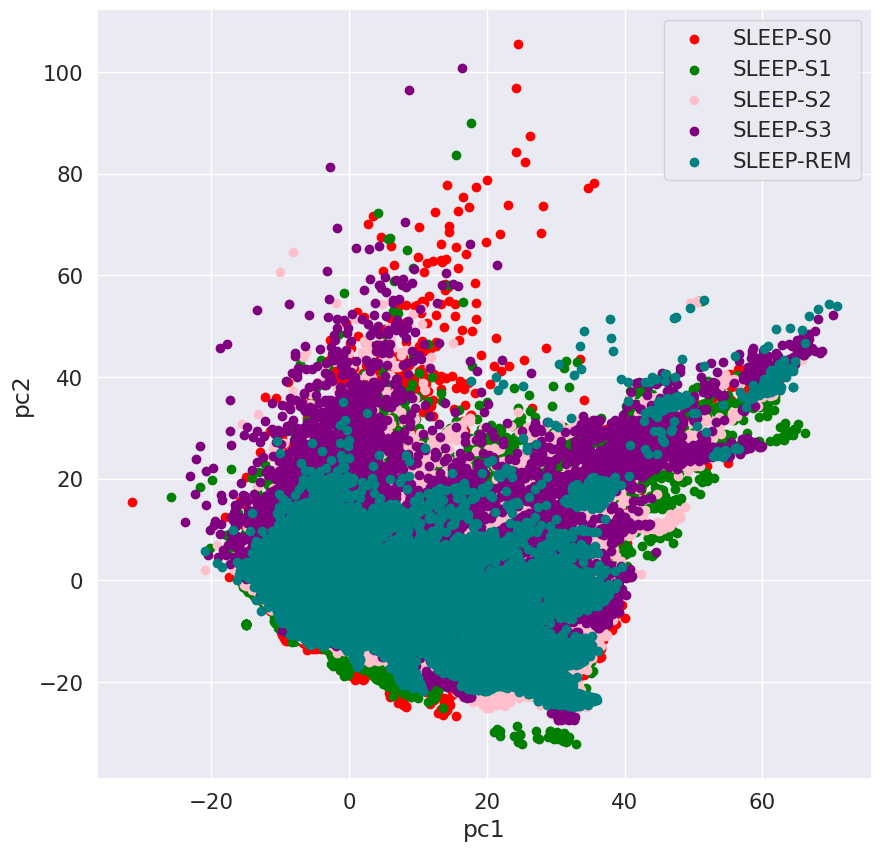

In [32]:
'''2D Plot Setup'''
fig = plt.figure(figsize=(10,10))
plt.figure(figsize=(10,10))
plt.xlabel('pc1')
plt.ylabel('pc2')

'''3D Plot Setup'''
axis = fig.add_subplot(111, projection='3d')
axis.set_xlabel("PC1", fontsize=14)
axis.set_ylabel("PC2", fontsize=14)
axis.set_zlabel("PC3", fontsize=14)

'''Add values to plots'''
cdict={0:'red',1:'green',2:'pink', 3:'purple', 4:'teal', 5:'blue', 6:'orange', 7:'yellow', 8:'grey', 9:'black'}#graph colors
class_names=['SLEEP-S0','SLEEP-S1', 'SLEEP-S2', 'SLEEP-S3', 'SLEEP-REM']
for l in np.unique(y_test):
 ix=np.where(y_test==l)
 axis.scatter(x[ix][:,0], x[ix][:,1], x[ix][:,2], cdict,
           label=class_names[l])
 plt.scatter(x[ix][:,0],x[ix][:,1],c=cdict[l],label=class_names[l])

'''plot'''
plt.legend()
axis.legend()
plt.show()